In [80]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

import mission_tools

%matplotlib widget

In [81]:
# load the offshore wave conditon dataframe
offshore_df = pd.read_csv('../microSWIFT_data/mission_df.csv')
offshore_df['Mean Dir [deg]'] = offshore_df['Mean Dir [deg]'] - 71.8
offshore_df.sort_values(by='Mean Dir [deg]', key=abs).head(20)

,Unnamed: 0,time,mission number,Hs [m],Tm [s],Mean Dir [deg],cross shore gamma location [m],break depth,freq [hz],energy density [m^2\hz],direction bins [deg],directional energy density [m^2/hz/deg],wind speed [m/s],wind direction [deg],water level [m]
55,55,2021-10-10 13:12:37.498650,20,2.651632,6.760199,0.786823,700.886919,7.576092,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.06929024949686123, 0.06325092216444662, 0.0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[0.0001469879935029894, 0.0001584396668476984...",13.475163,50.222300,1.047
22,22,2021-10-14 12:30:44.997660,33,0.829603,7.273393,0.853053,232.784504,2.370293,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.011721046226609442, 0.010334131626286842, 0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[2.4330131054739468e-05, 2.5680119506432675e-...",4.451416,333.810030,-0.211
65,65,2021-10-14 13:07:29.998200,34,0.828214,7.232409,1.307152,232.633715,2.366327,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.01278272131939542, 0.010030188729890517, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[2.4330131054739468e-05, 2.5680119506432675e-...",3.899167,334.037480,-0.257
46,46,2021-10-14 13:32:59.997600,35,0.827501,7.272422,1.443768,232.556191,2.364287,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.013373146863132334, 0.010611319421880495, 0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[2.888291419367306e-05, 2.9033777536824346e-0...",4.620583,338.784150,-0.234
33,33,2021-10-14 14:28:29.997960,36,0.837454,7.320752,1.983435,233.637291,2.392727,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.015045350121974358, 0.011407724947522591, 0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[2.888291419367306e-05, 2.9033777536824346e-0...",5.170833,332.844020,-0.135
37,37,2021-10-10 15:11:14.998980,22,2.505776,6.748559,-2.065561,644.757501,7.159360,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.05291931093519917, 0.047955870336011744, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[7.657991227461025e-05, 8.205428457586095e-05...",11.638000,43.624560,1.312
27,27,2021-10-14 15:16:29.999160,37,0.861440,7.326311,2.171019,236.242339,2.461256,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.01557180618311918, 0.011657329420557357, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[3.4845386835513636e-05, 3.6741868825629354e-...",4.064500,346.160460,-0.025
48,48,2021-10-10 14:15:59.997840,21,2.545949,6.712069,-2.541253,659.473662,7.274139,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.06351501732945555, 0.053363077691382314, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[0.00012216682080179453, 0.000133488429128192...",12.621826,36.249990,1.263
13,13,2021-10-14 17:28:59.996160,38,0.863505,7.170816,3.180486,236.466705,2.467159,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.013910650959027174, 0.01233431609238609, 0....","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[2.1191230189288035e-05, 2.254667015222367e-0...",3.911916,359.464700,0.556
9,9,2021-10-26 16:36:29.997240,59,1.148516,8.167008,3.767836,272.390264,3.281474,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.01948378813173654, 0.01623909523358334, 0.0...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[3.507368091959506e-05, 3.711074168677442e-05...",6.689464,300.994630,0.581


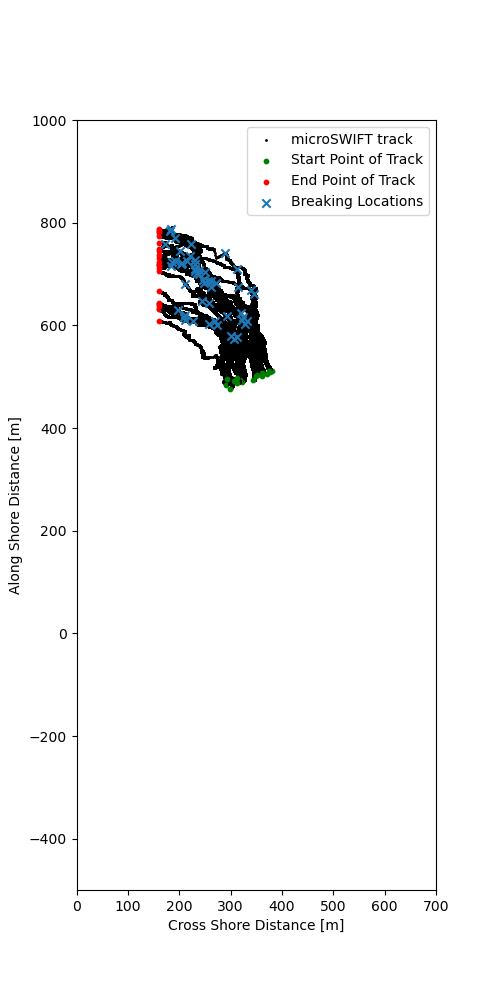

In [82]:
# Load mission 19 data and plot tracks over the radar image
mission_num = 74
mission_nc_path = f'../microSWIFT_data/final_dataset/mission_{mission_num}.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Load the breaker dataset
breaker_df = pd.read_csv('../microSWIFT_data/breaker_df.csv')
breaker_df_mission = breaker_df[breaker_df['mission number'] == mission_num]

# Plot the microSWIFT tracks over the radar image
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
time_vals = mission_dataset['time'][:]

fig, ax = plt.subplots(figsize=(5,10))

for n in range(mission_dataset['trajectory'].size-1):
    edge_inds_x = np.ma.flatnotmasked_edges(x_locations[n,:])
    edge_inds_y = np.ma.flatnotmasked_edges(y_locations[n,:])
    start_ind = np.max([edge_inds_x[0], edge_inds_y[0]])
    end_ind = np.min([edge_inds_x[1], edge_inds_y[1]])
    map = ax.scatter(x_locations[n,:],
                        y_locations[n,:],
                        c='k', s=1)
    map = ax.scatter(x_locations[n,start_ind],
                     y_locations[n,start_ind],
                     c='g', s=10)
    map = ax.scatter(x_locations[n,end_ind],
                     y_locations[n,end_ind],
                     c='r', s=10)
    
# plot last track and label points for legend
edge_inds_x = np.ma.flatnotmasked_edges(x_locations[-1,:])
edge_inds_y = np.ma.flatnotmasked_edges(y_locations[-1,:])
start_ind = np.max([edge_inds_x[0], edge_inds_y[0]])
end_ind = np.min([edge_inds_x[1], edge_inds_y[1]])
map = ax.scatter(x_locations[-1,:],
                    y_locations[-1,:],
                    c='k', s=1, label='microSWIFT track')
map = ax.scatter(x_locations[-1,start_ind],
                    y_locations[-1,start_ind],
                    c='g', s=10, label='Start Point of Track')
map = ax.scatter(x_locations[-1,end_ind],
                    y_locations[-1,end_ind],
                    c='r', s=10, label='End Point of Track')

# Scatter all Detected Breaking locations from the mission
ax.scatter(breaker_df_mission['cross shore location [m]'], breaker_df_mission['along shore location [m]'], 
           marker='x', label='Breaking Locations')

ax.set_xlim(0, 700)
ax.set_ylim(-500, 1000)
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.legend()
ax.set_aspect('equal')

In [83]:
# load the breaker event dataframe
breaker_df = pd.read_csv('../microSWIFT_data/breaker_df.csv')
breaker_mission_df = breaker_df[breaker_df['mission number'] == mission_num]
breaker_mission_df

,Unnamed: 0,time,mission number,cross shore location [m],cross shore location normalized [m],along shore location [m]
1943,1943,2021-10-29 12:17:17.457424,74.0,226.568693,0.423276,608.798345
1944,1944,2021-10-29 12:17:32.457364,74.0,209.253245,0.390927,615.604129
1945,1945,2021-10-29 12:16:42.457564,74.0,273.181233,0.510357,601.453444
1946,1946,2021-10-29 12:17:32.457364,74.0,211.839919,0.395759,620.793124
1947,1947,2021-10-29 12:17:47.457304,74.0,197.307035,0.368609,629.391386
1948,1948,2021-10-29 12:19:57.456784,74.0,231.629943,0.432731,705.296546
1949,1949,2021-10-29 12:20:02.456764,74.0,231.640014,0.432750,709.060277
1950,1950,2021-10-29 12:18:37.457103,74.0,244.373129,0.456538,647.997537
1951,1951,2021-10-29 12:19:42.456844,74.0,210.752384,0.393728,681.325648
1952,1952,2021-10-29 12:16:57.457504,74.0,269.515337,0.503509,608.668491


In [84]:
mission_df = offshore_df[offshore_df['mission number'] == mission_num]
mission_df

,Unnamed: 0,time,mission number,Hs [m],Tm [s],Mean Dir [deg],cross shore gamma location [m],break depth,freq [hz],energy density [m^2\hz],direction bins [deg],directional energy density [m^2/hz/deg],wind speed [m/s],wind direction [deg],water level [m]
43,43,2021-10-29 12:18:14.998860,74,2.146874,7.012196,7.269354,535.27464,6.133927,"[0.03999999910593033, 0.04749999940395355, 0.0...","[0.05428458417097456, 0.08296063051668814, 0.5...","[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...","[[0.00010070204007206485, 0.000111208821181207...",12.2105,137.2305,0.348


In [85]:
# Compute Stokes Drift Estimate from offshore conditions
g = 9.8 
Tm = mission_df['Tm [s]'].values[0]
Hs = mission_df['Hs [m]'].values[0]
stokes_drift = (((2 * np.pi)**3 / g) * Hs**2 / Tm**3)
print(stokes_drift)

0.338348782526907


In [86]:
# Solve for Offshore Wavelength
lambda_m = 1 / mission_tools.solve_dispersion_relation(9.8, 8, 2*np.pi/Tm)
print(lambda_m)

8.798028444159643


In [87]:
# Split trajectories from mission 19 into bins
window_size_seconds = int(Tm) # 2 minutes 
window_size = window_size_seconds * 12
time = np.linspace(0, window_size_seconds, num=window_size)

# get bathy data
bathy_dataset = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
bathy_xFRF = bathy_dataset['xFRF'][:]
bathy_yFRF = bathy_dataset['yFRF'][:]
bathy = bathy_dataset['elevation'][0,:,:]
bathy_f = interpolate.interp2d(bathy_xFRF, bathy_yFRF, bathy)

# Set the breaking window size
breaking_window_size = 60 # 5 seconds at 12 Hz

# Set the breaking threshold from the breaker dataset
breaking_threshold = 2.5

breaking_tracks = []
breaking_velocity = []
nonbreaking_tracks = []
nonbreaking_velocity = []
max_vel = []

num_microswifts = x_locations.shape[0]
for microswift_num in range(num_microswifts):
    x_location_indiv = x_locations[microswift_num,:]
    x_location_indiv_reshape = np.reshape(x_location_indiv[:(x_location_indiv.size//window_size * window_size)],
                                (x_location_indiv.size//window_size, window_size))
    
    y_location_indiv = y_locations[microswift_num,:]
    y_location_indiv_reshape = np.reshape(y_location_indiv[:(y_location_indiv.size//window_size * window_size)],
                                (y_location_indiv.size//window_size, window_size))
    
    cross_shore_vel = np.gradient(x_location_indiv_reshape, 1/12, axis=1)
    max_vel.append(np.max(cross_shore_vel))

    # Phase speed in segment
    x_location_mean_segment = np.nanmean(x_location_indiv_reshape, axis=1)
    y_location_mean_segment = np.nanmean(y_location_indiv_reshape, axis=1)

    num_segments = x_location_indiv_reshape.shape[0]

    # Get breaking events in each segment
    for n in range(num_segments):
        # phase speed in segment
        depth_in_segment = np.squeeze(bathy_f(x_location_mean_segment[n],
                                             y_location_mean_segment[n]).item())
        c = np.sqrt(9.8 * np.abs(depth_in_segment))

        breaking_in_segment = np.any(np.abs(cross_shore_vel[n,:]) > 0.3*c)

        if breaking_in_segment:
            breaking_tracks.append(x_location_indiv_reshape[n,:])
            breaking_velocity.append(cross_shore_vel[n,:])

        else:
            nonbreaking_tracks.append(x_location_indiv_reshape[n,:])
            nonbreaking_velocity.append(cross_shore_vel[n,:])


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_22468/2804007857.py:11: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  bathy_f = interpolate.interp2d(bathy_xFRF, bathy_yFRF, bathy)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_22468/2804007857.py:47: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular g

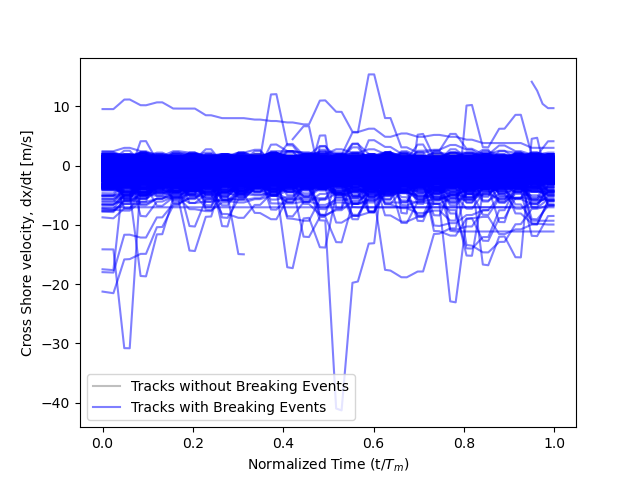

In [88]:
fig, ax = plt.subplots()
for n in range(len(nonbreaking_velocity)-1):
    ax.plot(time/Tm, (nonbreaking_velocity[n]), color='gray', alpha=0.5)
ax.plot(time/Tm,  nonbreaking_velocity[n], color='gray', label='Tracks without Breaking Events', alpha=0.5)

for n in range(len(breaking_tracks)-1):
    ax.plot(time/Tm, breaking_velocity[n][:], color='blue', alpha=0.5)
ax.plot(time/Tm, breaking_velocity[n][:], color='blue', label='Tracks with Breaking Events', alpha=0.5)

ax.set_xlabel('Normalized Time (t/$T_m)$')
ax.set_ylabel('Cross Shore velocity, dx/dt [m/s]')
ax.legend()

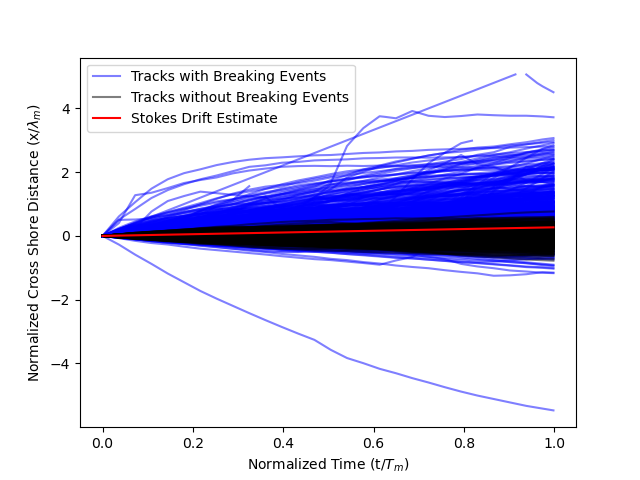

In [89]:
fig, ax = plt.subplots()
for n in range(len(breaking_tracks)-1):
    ax.plot(time/Tm, (breaking_tracks[n][0] - breaking_tracks[n][:])/lambda_m, color='blue', alpha=0.5)
ax.plot(time/Tm, (breaking_tracks[n][0] - breaking_tracks[n][:])/lambda_m, color='blue', label='Tracks with Breaking Events', alpha=0.5)

for n in range(len(nonbreaking_tracks)-1):
    ax.plot(time/Tm, (nonbreaking_tracks[n][0] - nonbreaking_tracks[n][:])/lambda_m, color='k', alpha=0.5)
ax.plot(time/Tm, (nonbreaking_tracks[n][0] - nonbreaking_tracks[n][:])/lambda_m, color='k', label='Tracks without Breaking Events', alpha=0.5)

# Stokes Drift Estimate
ax.plot(time/Tm, (stokes_drift * (time))/lambda_m, color='r', label='Stokes Drift Estimate')

ax.set_xlabel('Normalized Time (t/$T_m)$')
ax.set_ylabel('Normalized Cross Shore Distance (x/$\lambda_m$)')
ax.legend()

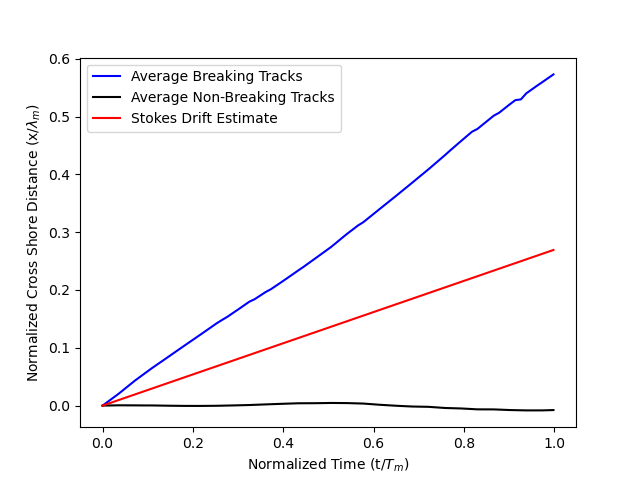

In [90]:
# Average the normalized breaking and nonbreaking tracks
breaking_tracks_norm = np.empty((len(breaking_tracks), time.size))
for n in range(breaking_tracks_norm.shape[0]):
    breaking_tracks_norm[n,:] = (breaking_tracks[n].filled(np.nan)[0] - breaking_tracks[n].filled(np.nan))/lambda_m

nonbreaking_tracks_norm = np.empty((len(nonbreaking_tracks), time.size))
for n in range(nonbreaking_tracks_norm.shape[0]):
    nonbreaking_tracks_norm[n,:] = (nonbreaking_tracks[n].filled(np.nan)[0] - nonbreaking_tracks[n].filled(np.nan))/lambda_m

time_norm = time/Tm

# Average Tracks
breaking_tracks_norm_avg = np.nanmean(breaking_tracks_norm, axis=0)
nonbreaking_tracks_norm_avg = np.nanmean(nonbreaking_tracks_norm, axis=0)

# Track standard deviation
breaking_tracks_norm_std = np.nanstd(breaking_tracks_norm, axis=0)
nonbreaking_tracks_norm_std = np.nanstd(nonbreaking_tracks_norm, axis=0)

fig, ax = plt.subplots()
ax.plot(time_norm, breaking_tracks_norm_avg, color='blue', label='Average Breaking Tracks')

ax.plot(time_norm, nonbreaking_tracks_norm_avg, color='k', label='Average Non-Breaking Tracks')

ax.plot(time/Tm, (stokes_drift * (time))/lambda_m, color='r', label='Stokes Drift Estimate')
ax.set_xlabel('Normalized Time (t/$T_m)$')
ax.set_ylabel('Normalized Cross Shore Distance (x/$\lambda_m$)')
ax.legend()

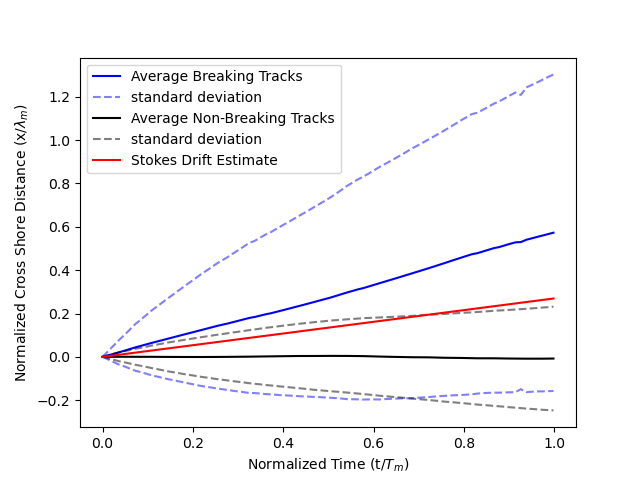

In [91]:
fig, ax = plt.subplots()
ax.plot(time_norm, breaking_tracks_norm_avg, color='blue', label='Average Breaking Tracks')
ax.plot(time_norm, breaking_tracks_norm_avg-breaking_tracks_norm_std, color='blue', alpha=0.5, linestyle='dashed')
ax.plot(time_norm, breaking_tracks_norm_avg+breaking_tracks_norm_std, color='blue', alpha=0.5, linestyle='dashed', label='standard deviation')

ax.plot(time_norm, nonbreaking_tracks_norm_avg, color='k', label='Average Non-Breaking Tracks')
ax.plot(time_norm, nonbreaking_tracks_norm_avg-nonbreaking_tracks_norm_std, color='k', alpha=0.5, linestyle='dashed', label='standard deviation')
ax.plot(time_norm, nonbreaking_tracks_norm_avg+nonbreaking_tracks_norm_std, color='k', alpha=0.5, linestyle='dashed')

ax.plot(time/Tm, (stokes_drift * (time))/lambda_m, color='r', label='Stokes Drift Estimate')
ax.set_xlabel('Normalized Time (t/$T_m)$')
ax.set_ylabel('Normalized Cross Shore Distance (x/$\lambda_m$)')
ax.legend()